Step 1 – Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 2 – Set the data path

In [5]:
import os

base_dir = "/content/drive/MyDrive/all_data"

print(os.listdir(base_dir))


['Tomato_Healthy', 'Tomato_Bacterial_Spot']


Step 3 - Create clean train/ and valid/ splits

In [6]:
import os
import shutil
import random
from glob import glob

# -------- paths --------
base_dir = "/content/drive/MyDrive/all_data"  # same as above
classes = ["Tomato_Bacterial_Spot", "Tomato_Healthy"]

root_out = "/content/drive/MyDrive/data"  # new dataset root
train_dir = os.path.join(root_out, "train")
valid_dir = os.path.join(root_out, "valid")

# create folders
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(valid_dir, cls), exist_ok=True)

# split each class
split_ratio = 0.8  # 80% train, 20% valid

for cls in classes:
    src_folder = os.path.join(base_dir, cls)
    images = glob(os.path.join(src_folder, "*"))
    random.shuffle(images)

    split_idx = int(len(images) * split_ratio)
    train_files = images[:split_idx]
    valid_files = images[split_idx:]

    print(f"{cls}: total={len(images)}, train={len(train_files)}, valid={len(valid_files)}")

    # copy to train
    for f in train_files:
        shutil.copy(f, os.path.join(train_dir, cls, os.path.basename(f)))

    # copy to valid
    for f in valid_files:
        shutil.copy(f, os.path.join(valid_dir, cls, os.path.basename(f)))

print("Done! Clean train/valid split created at:", root_out)


Tomato_Bacterial_Spot: total=2127, train=1701, valid=426
Tomato_Healthy: total=1926, train=1540, valid=386
Done! Clean train/valid split created at: /content/drive/MyDrive/data


Step 4 - Load the new dataset in Colab

In [9]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

data_root = "/content/drive/MyDrive/data"
train_dir = os.path.join(data_root, "train")
valid_dir = os.path.join(data_root, "valid")

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 4101 files belonging to 2 classes.
Found 1958 files belonging to 2 classes.
Classes: ['Tomato_Bacterial_Spot', 'Tomato_Healthy']


Step 5 - Add prefetch + augmentation

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(AUTOTUNE)


Step 6 - Build VGG16 transfer learning model

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

num_classes = len(class_names)

base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

base_model.trainable = False  # freeze base

inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2)         │      1,026 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,715,714 (56.14 MB)

 Trainable params: 1,026 (4.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Step 7 - Train the model

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import os

# ---- compute class weights from train folder ----
train_root = "/content/drive/MyDrive/data/train"

class_counts = []
for idx, cls in enumerate(class_names):
    folder = os.path.join(train_root, cls)
    n = len(os.listdir(folder))
    class_counts.append(n)
    print(f"{cls}: {n} images in TRAIN")

total = float(sum(class_counts))
num_classes = len(class_counts)

class_weight = {
    i: total / (num_classes * class_counts[i])
    for i in range(num_classes)
}
print("\nClass weights:", class_weight)

# ---- early stopping ----
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# ---- recompile with smaller LR ----
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

EPOCHS = 30

history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    callbacks=[early_stop],
    class_weight=class_weight
)


Tomato_Bacterial_Spot: 2203 images in TRAIN
Tomato_Healthy: 1898 images in TRAIN

Class weights: {0: 0.9307762142532909, 1: 1.0803477344573236}
Epoch 1/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.5989 - loss: 2.0712 - val_accuracy: 0.7385 - val_loss: 0.6470
Epoch 2/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 23s 180ms/step - accuracy: 0.6407 - loss: 1.0814 - val_accuracy: 0.8350 - val_loss: 0.3651
Epoch 3/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 24s 184ms/step - accuracy: 0.7347 - loss: 0.7135 - val_accuracy: 0.9014 - val_loss: 0.2250
Epoch 4/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 24s 188ms/step - accuracy: 0.7704 - loss: 0.5880 - val_accuracy: 0.9377 - val_loss: 0.1537
Epoch 5/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 24s 186ms/step - accuracy: 0.8290 - loss: 0.4358 - val_accuracy: 0.9622 - val_loss: 0.1117
Epoch 6/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 24s 185ms/step - accuracy: 0.8732 - loss: 0.3065 - val_accuracy: 0.9740 - val_loss: 0.0871
Epoch 7/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 24s 186ms/step - accuracy: 0.888

In [13]:
# ---- FINE-TUNING VGG16 ----

# unfreeze the base model
base_model.trainable = True

# keep lower layers frozen, only train the top convolutional block
for layer in base_model.layers[:-4]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # even smaller LR
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("Trainable layers:", len([l for l in model.layers if l.trainable]))

history_fine = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,
    callbacks=[early_stop],
    class_weight=class_weight
)


Trainable layers: 6
Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - accuracy: 0.9915 - loss: 0.0271 - val_accuracy: 1.0000 - val_loss: 1.5532e-04
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 28s 220ms/step - accuracy: 0.9990 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 4.8653e-05
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 28s 216ms/step - accuracy: 0.9997 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 2.4596e-04
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 28s 219ms/step - accuracy: 1.0000 - loss: 4.6659e-04 - val_accuracy: 0.9995 - val_loss: 0.0021
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 28s 219ms/step - accuracy: 1.0000 - loss: 2.9702e-04 - val_accuracy: 1.0000 - val_loss: 1.2901e-04


Step 8 - Evaluate and visualize

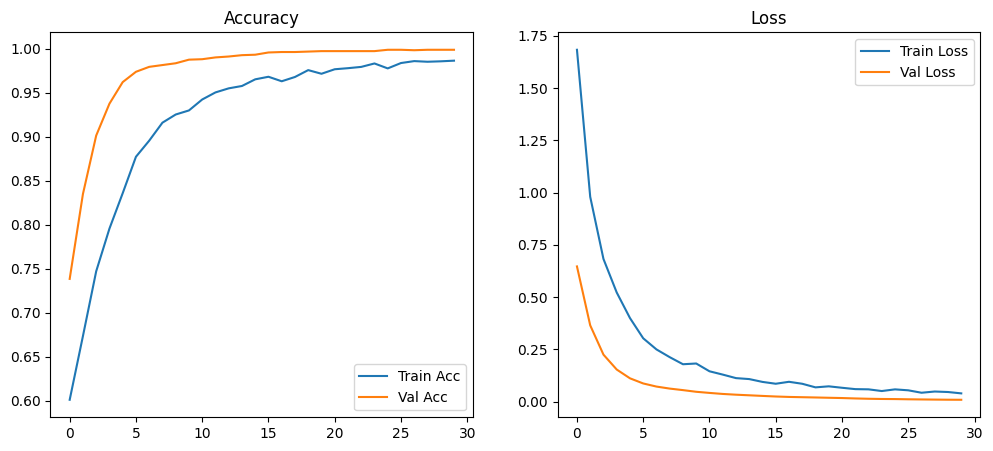

In [14]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()


In [15]:
import numpy as np
from sklearn.metrics import classification_report

y_true, y_pred = [], []

for images, labels in valid_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Saving Bacterial-speck-tomato-leaves-e1721248780829.jpg to Bacterial-speck-tomato-leaves-e1721248780829 (3).jpg
Using image: /content/Bacterial-speck-tomato-leaves-e1721248780829 (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Predicted Class: Tomato_Bacterial_Spot
Confidence: 0.9999875


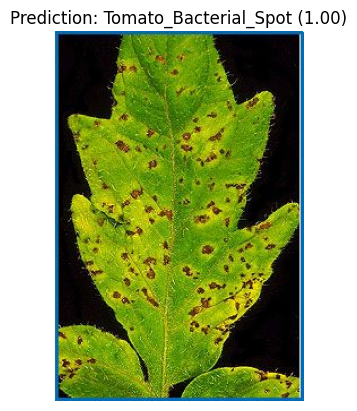


Class probabilities:
Tomato_Bacterial_Spot: 1.0000
Tomato_Healthy: 0.0000


In [18]:
from google.colab import files
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

# 1) Upload an image
uploaded = files.upload()

# 2) Get the uploaded filename automatically
filename = list(uploaded.keys())[0]   # first (and usually only) uploaded file
img_path = os.path.join("/content", filename)
print("Using image:", img_path)

# 3) Load and preprocess the image
IMG_SIZE = (224, 224)  # same as training
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.vgg16.preprocess_input(img_array)

# 4) Predict
predictions = model.predict(img_array)
pred_class = np.argmax(predictions)
confidence = predictions[0][pred_class]

print("\nPredicted Class:", class_names[pred_class])
print("Confidence:", confidence)

# 5) Show image with label
plt.imshow(image.load_img(img_path))
plt.title(f"Prediction: {class_names[pred_class]} ({confidence:.2f})")
plt.axis("off")
plt.show()

# 6) (Optional) show all class probabilities
print("\nClass probabilities:")
for i, cls in enumerate(class_names):
    print(f"{cls}: {predictions[0][i]:.4f}")
